In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-03-06 12:58:47--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.156.83.58, 108.156.83.50, 108.156.83.2, ...
Connecting to segment-anything.com (segment-anything.com)|108.156.83.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.05s   

2024-03-06 12:58:47 (4.03 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


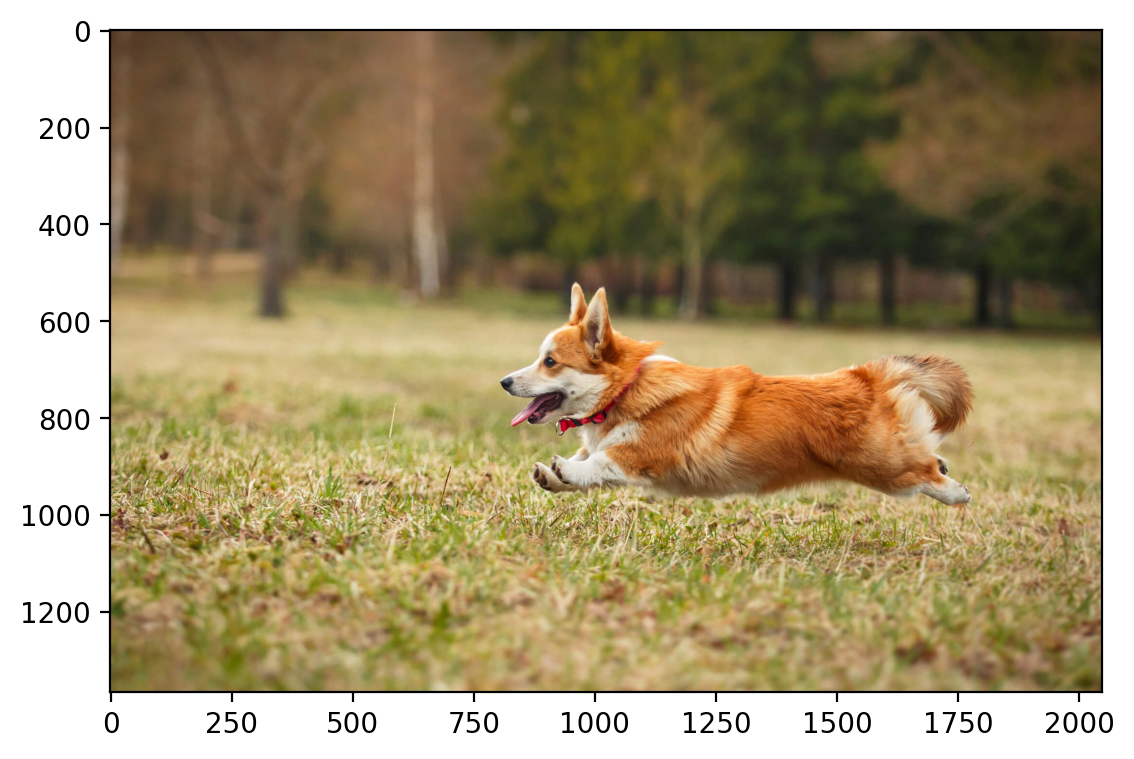

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape
crop.to(device)

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

In [ ]:
crop_=crop.cpu().detach().numpy()

In [ ]:
crop_

array([[[0.76862745, 0.76862745, 0.76862745, ..., 0.54509804,
         0.54509804, 0.54117647],
        [0.77254902, 0.77254902, 0.77254902, ..., 0.56862745,
         0.56862745, 0.56470588],
        [0.77647059, 0.77647059, 0.77647059, ..., 0.58823529,
         0.58431373, 0.58431373],
        ...,
        [0.79607843, 0.7372549 , 0.71764706, ..., 0.58431373,
         0.57254902, 0.54901961],
        [0.84705882, 0.78431373, 0.74509804, ..., 0.60392157,
         0.56862745, 0.55686275],
        [0.87843137, 0.81960784, 0.76862745, ..., 0.62745098,
         0.58039216, 0.56862745]],

       [[0.69411765, 0.69411765, 0.69411765, ..., 0.51372549,
         0.51372549, 0.50980392],
        [0.69803922, 0.69803922, 0.69803922, ..., 0.5254902 ,
         0.5254902 , 0.52156863],
        [0.70196078, 0.70196078, 0.70196078, ..., 0.54509804,
         0.54117647, 0.54117647],
        ...,
        [0.76862745, 0.70980392, 0.68627451, ..., 0.28235294,
         0.27058824, 0.24313725],
        [0.8

In [ ]:
from sklearn.linear_model import LinearRegression
def upscale(image):
    height, width = image.shape[1:]
    upscaled_height = height * 2
    upscaled_width = width * 2
    print("height: ",height)
    print("width: ",width)
    upscaled_image = np.zeros((3, upscaled_height, upscaled_width),dtype=float)
    for i in range(0, height, 2):
        for j in range(0, width, 2):
            # Extract 2x2 block
            block = image[:, i:i+2, j:j+2]
            block1=block[0].reshape(1,-1)
            block2=block[1].reshape(1,-1)
            block3=block[2].reshape(1,-1)
            block_=np.vstack((block1,block2,block3)).T
            # Reshape block for linear regression
            X = np.array([[i, j], [i+1, j], [i, j+1], [i+1, j+1]],dtype=float)

            model = LinearRegression()
            model.fit(X, block_)
            X_new = np.array([[x, y] for x in np.linspace(i,i+1,4) for y in np.linspace(j,j+1,4)])
            interpolated_block = model.predict(X_new)
            interpolated_block1=interpolated_block[:,0].reshape(4,4)
            interpolated_block2=interpolated_block[:,1].reshape(4,4)
            interpolated_block3=interpolated_block[:,2].reshape(4,4)
            interpolated_block_=np.stack((interpolated_block1,interpolated_block2,interpolated_block3),axis=0)
            upscaled_image[:,2*i:2*i+4,2*j:2*j+4]=interpolated_block_
    return upscaled_image





height:  300
width:  300


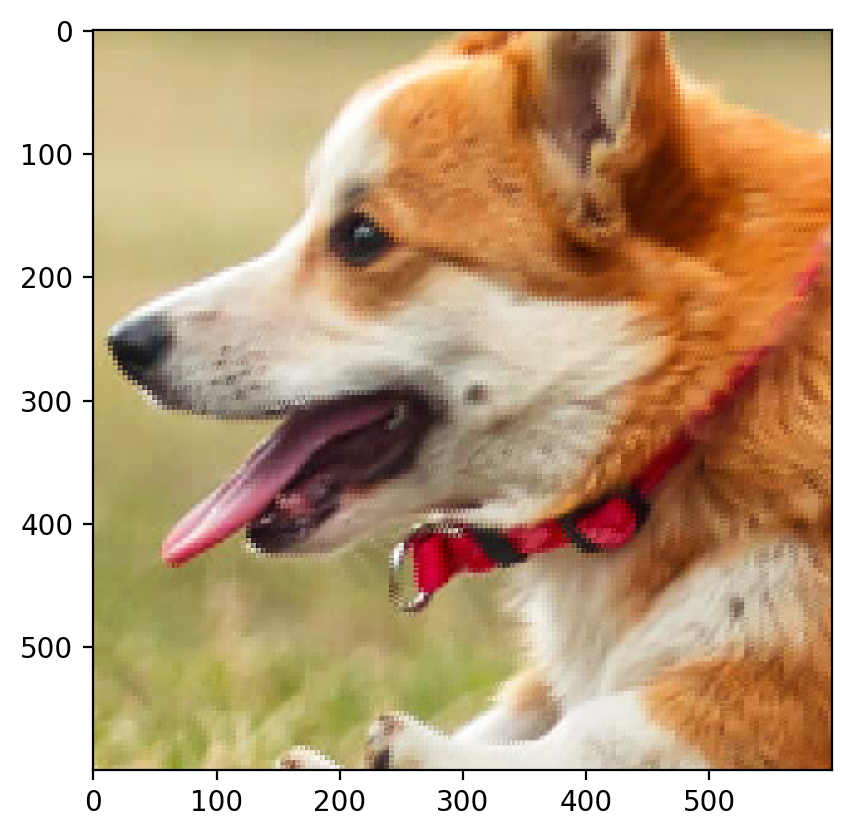

In [ ]:
upImg=upscale(crop_)

plt.imshow(rearrange(torch.tensor(upImg), 'c h w -> h w c').numpy())

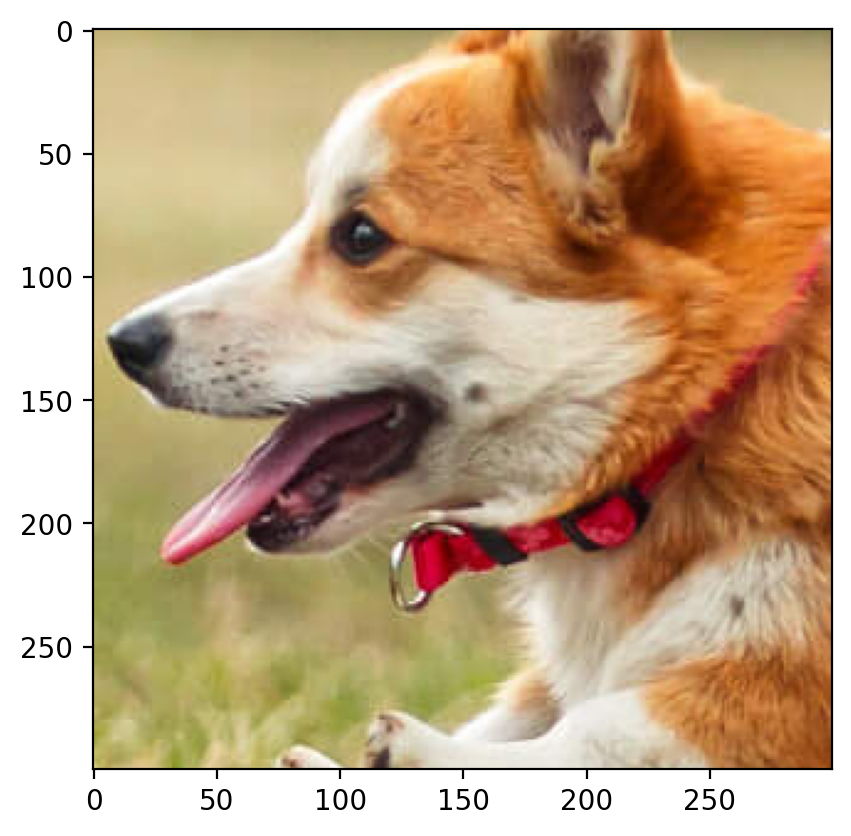

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').numpy())